# Описание проекта
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [203]:
                               import numpy as np
                               import pandas as pd
                               import seaborn as sns
                               import matplotlib.pyplot as plt                               
from sklearn.model_selection   import train_test_split
from sklearn.model_selection   import cross_val_score, cross_val_predict , KFold
from sklearn.preprocessing     import OrdinalEncoder
from sklearn.linear_model      import Lasso , Ridge 
from sklearn.ensemble          import RandomForestRegressor
from sklearn.metrics           import *
                               import lightgbm as lgb
                               import warnings
                               import time
from catboost                  import CatBoostRegressor , Pool , cv , CatBoost
warnings.filterwarnings("ignore")

In [177]:
df_autos = pd.read_csv("/home/ivan/Yandex.Disk/DS/Project_9/autos.csv")

In [178]:
df_autos['NumberOfPictures'].unique()

array([0])

In [179]:
df_autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [180]:
df_autos.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [181]:
df_autos.select_dtypes('object').head(5)

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
0,2016-03-24 11:52:17,NaN,manual,golf,petrol,volkswagen,NaN,2016-03-24 00:00:00,2016-04-07 03:16:57
1,2016-03-24 10:58:45,coupe,manual,NaN,gasoline,audi,yes,2016-03-24 00:00:00,2016-04-07 01:46:50
2,2016-03-14 12:52:21,suv,auto,grand,gasoline,jeep,NaN,2016-03-14 00:00:00,2016-04-05 12:47:46
3,2016-03-17 16:54:04,small,manual,golf,petrol,volkswagen,no,2016-03-17 00:00:00,2016-03-17 17:40:17
4,2016-03-31 17:25:20,small,manual,fabia,gasoline,skoda,no,2016-03-31 00:00:00,2016-04-06 10:17:21


### Анализ и заполнение пропусков

In [182]:
# Процент пропусков 
df_autos.isna().sum()/df_autos.shape[0]

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

In [183]:
df_autos[['VehicleType', 'Brand', 'Model' , 'Gearbox']]

,VehicleType,Brand,Model,Gearbox
0,NaN,volkswagen,golf,manual
1,coupe,audi,NaN,manual
2,suv,jeep,grand,auto
3,small,volkswagen,golf,manual
4,small,skoda,fabia,manual
...,...,...,...,...
354364,NaN,mitsubishi,colt,manual
354365,NaN,sonstige_autos,NaN,NaN
354366,convertible,smart,fortwo,auto
354367,bus,volkswagen,transporter,manual


In [184]:
df_autos['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [185]:
df_autos['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [186]:
df_autos['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [187]:
df_autos[ df_autos['Model'].isna()].head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29 00:00:00,0,53721,2016-04-06 01:44:38
81,2016-04-03 12:56:45,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,2016-04-03 00:00:00,0,45665,2016-04-05 11:47:13
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
135,2016-03-27 20:51:23,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,2016-03-27 00:00:00,0,38709,2016-04-05 20:17:31


In [188]:
df_autos[df_autos['Brand'] !='sonstige_autos'].head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [189]:
df_autos['NumberOfPictures'].unique()

array([0])

In [190]:
# Функция заполняет/удаляет пропуски
def missing_values(data):
    data = data.dropna(axis = 0 , subset = ['Model'])
    data[['VehicleType' , 'FuelType']] = data[['VehicleType' , 'FuelType']].fillna('other') 
    data['Gearbox'] = data['Gearbox'].fillna('other') 
    data['NotRepaired'] = data['NotRepaired'].fillna('not_repaired_nan')
    data = data.drop('NumberOfPictures' , axis=1)        #  удаляем столбец с количеством фото
    return data

### Вывод:

- VehicleType. Пропуски заполнены значениями 'other', которое уже есть в датасете.
- Gearbox. Пропуски заполнены значениями 'other', т.к.  неизвестно по каким причинам пропуск, и может быть коробка "робот".
- FuelType. Пропуски заполнены значениями 'other', которое уже есть в датасете.
- Model. Удалены строки с пропусками, т.к. их количество не значительно - всего 5,5%.
- NotRepaired. Возможно, что машина в среднем состоянии. Добавлена категория not_repaired_nan
- NumberOfPictures. Признак удален, т.к. все значения нулевые

  ### Анализ целевого признака

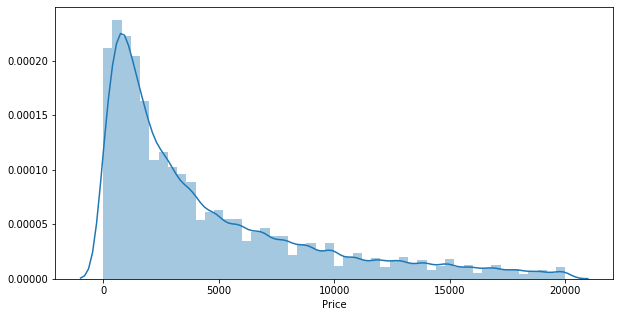

In [191]:
# Рапределение значение целевого признака
plt.figure(figsize =(10,5))
sns.distplot(df_autos['Price']);

In [192]:
df_autos['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [193]:
# Количество  значений цены меньше 100
df_autos[df_autos['Price']<100].shape

(13314, 16)

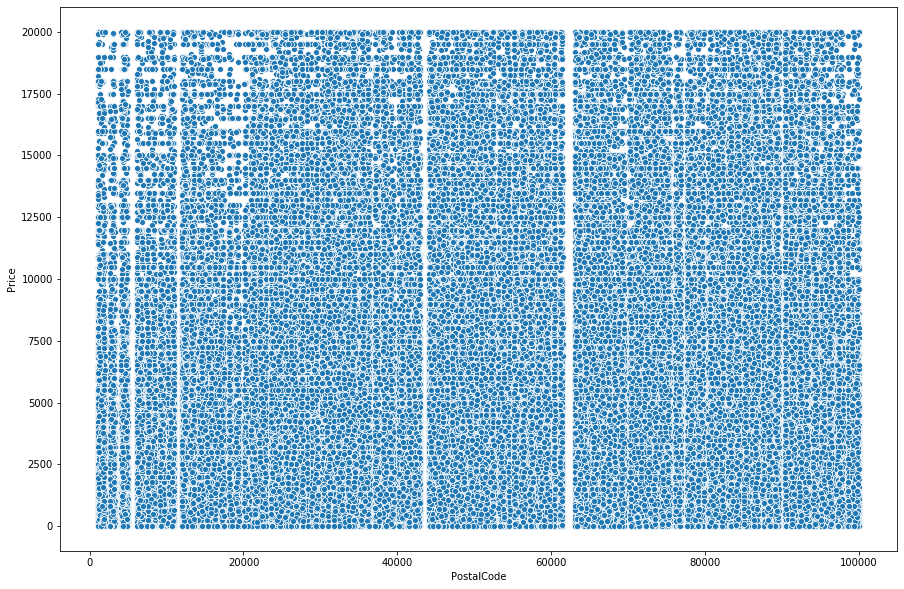

In [194]:
# Зависимость Price от PostalCode
plt.figure(figsize = (15,10))
sns.scatterplot(df_autos['PostalCode'] , df_autos['Price']);

In [195]:
# Корреляция признаков
df_autos.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


In [196]:
 # Функция удаляет выбросы по цене
def outliers_remove(data):
    data = data[data['Price'] >= 100]
    return data

### Features encoding

In [197]:
# Функция преобразовывает строки категориальных признаков в числа 
def ohe(data):
    # выделяем категориальные фичи
    cat_features = ['VehicleType' , 'Gearbox' , 'Model' , 'FuelType' , 'Brand' , 'NotRepaired']
    encoder = OrdinalEncoder(dtype = 'int64')
    data_encoded = encoder.fit_transform(data[cat_features])
    df_encoded = pd.DataFrame(data = data_encoded , columns = cat_features)
    return pd.concat([df_encoded , data[set(data.columns)-set(cat_features)]] , axis=1)    

### Преобразование дат и создание новых фич

In [198]:
# Функция преобразовывает даты в правильный формат и добавляет продолжительности
def date_transform(data):
    date_columns = ['DateCrawled', 'DateCreated' , 'LastSeen']
    # Преобразовываем дату
    for col in date_columns:
        data[col] = pd.to_datetime(data[col] , format = '%Y-%m-%d %H:%M:%S')
    
    # Добавляем признак - активность анкеты в днях
    data['Duration_days']= (data['LastSeen'] - data['DateCrawled']).dt.days + 1
    # Добавляем признак - возраст машины
    data['Car_age_months'] = ((pd.DatetimeIndex(data['DateCreated']).year - data['RegistrationYear'])*12 
                            + data['RegistrationMonth'])+1
    # Относительная дата создания анкеты
    data['Relative_date_created'] = (data['DateCreated'] - data['DateCreated'].min()).dt.days
                                    
    return data

In [199]:
date_columns = ['DateCrawled', 'DateCreated' , 'LastSeen']
    # Преобразовываем дату
for col in date_columns:
        df_autos[col] = pd.to_datetime(df_autos[col] , format = '%Y-%m-%d %H:%M:%S')
(df_autos['DateCreated'] - df_autos['DateCreated'].min()).sort_values()

61207      0 days
4001     375 days
342275   465 days
86601    515 days
175103   518 days
           ...   
134418   759 days
176987   759 days
206303   759 days
309336   759 days
305430   759 days
Name: DateCreated, Length: 354369, dtype: timedelta64[ns]

In [200]:
# Функция применяет все функции на этапах анализа
def main(data):
    data = missing_values(data)                          # удаляем пропуски
    data = outliers_remove(data).reset_index(drop=True)  # удаляем выбросы
    data = ohe(data)                                     # преобразовываем категориальные признаки в числа
    data = date_transform(data)                          # преобразовываем дату
    return data

In [201]:
# Записываем результат работы функции в переменную
df_autos_final = main(df_autos)
df_autos_final.head(5)

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCrawled,DateCreated,PostalCode,Kilometer,RegistrationMonth,Price,Power,RegistrationYear,LastSeen,Duration_days,Car_age_months,Relative_date_created
0,3,1,116,6,37,1,2016-03-24 11:52:17,2016-03-24,70435,150000,0,480,0,1993,2016-04-07 03:16:57,14,277,745
1,6,0,117,2,14,1,2016-03-14 12:52:21,2016-03-14,90480,125000,8,9800,163,2004,2016-04-05 12:47:46,22,153,735
2,5,1,116,6,37,0,2016-03-17 16:54:04,2016-03-17,91074,150000,6,1500,75,2001,2016-03-17 17:40:17,1,187,738
3,5,1,101,2,31,0,2016-03-31 17:25:20,2016-03-31,60437,90000,7,3600,69,2008,2016-04-06 10:17:21,6,104,752
4,4,1,11,6,2,2,2016-04-04 17:36:23,2016-04-04,33775,150000,10,650,102,1995,2016-04-06 19:17:07,3,263,756


In [202]:
# Проверим итоговую корреляцию признаков с ценой
corr_matrix = abs(df_autos_final.corr())  # Рассматриваем абсолютное значение корреляции
corr = corr_matrix.sort_values(by='Price' , ascending = False)
corr

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,PostalCode,Kilometer,RegistrationMonth,Price,Power,RegistrationYear,Duration_days,Car_age_months,Relative_date_created
Price,0.064355,0.258729,0.023331,0.282157,0.114074,0.269840,0.070333,0.372652,0.084685,1.000000,0.162087,0.054042,0.149121,0.053577,0.011187
Kilometer,0.040109,0.021160,0.034495,0.148984,0.042904,0.098912,0.011477,1.000000,0.008154,0.372652,0.019513,0.058032,0.071392,0.057985,0.000089
FuelType,0.049506,0.119180,0.031719,1.000000,0.034343,0.050850,0.010099,0.148984,0.066188,0.282157,0.057643,0.026434,0.004526,0.026070,0.012334
NotRepaired,0.001346,0.086246,0.017048,0.050850,0.008766,1.000000,0.022184,0.098912,0.111042,0.269840,0.044962,0.004513,0.068183,0.003905,0.003455
Gearbox,0.053791,1.000000,0.051336,0.119180,0.109012,0.086246,0.021645,0.021160,0.079269,0.258729,0.144066,0.010917,0.037844,0.011350,0.001374
Power,0.003333,0.144066,0.044325,0.057643,0.094477,0.044962,0.019195,0.019513,0.032540,0.162087,1.000000,0.000073,0.022982,0.000105,0.002197
Duration_days,0.012299,0.037844,0.009045,0.004526,0.017373,0.068183,0.030594,0.071392,0.001756,0.149121,0.022982,0.003287,1.000000,0.003279,0.438964
Brand,0.052739,0.109012,0.461600,0.034343,1.000000,0.008766,0.062627,0.042904,0.015126,0.114074,0.094477,0.000594,0.017373,0.000676,0.002123
RegistrationMonth,0.034111,0.079269,0.012373,0.066188,0.015126,0.111042,0.007797,0.008154,1.000000,0.084685,0.032540,0.006695,0.001756,0.012165,0.003587
PostalCode,0.013408,0.021645,0.047208,0.010099,0.062627,0.022184,1.000000,0.011477,0.007797,0.070333,0.019195,0.000200,0.030594,0.000243,0.015179


### Вывод:

**Обработка пропусков**
- VehicleType. Пропуски заполнены значениями 'other', которое уже есть в датасете.
- Gearbox. Пропуски заполнены значениями 'other', т.к.  неизвестно по каким причинам пропуск, и может быть коробка "робот".
- FuelType. Пропуски заполнены значениями 'other', которое уже есть в датасете.
- Model. Удалены строки с пропусками, т.к. их количество не значительно - всего 5,5%.
- NotRepaired. Возможно, что машина в среднем состоянии. Добавлена категория not_repaired_nan
- NumberOfPictures. Признак удален, т.к. все значения нулевые.

**Анализ целевого признака**

Для реалистичности модели исключены строки со значениями цены менее 100.


**Features encoding**

Методом OrdinalEncoder() строковые значения преобразованы в числовые. Таким образом каждые признак состоит из числовых значений.

**Преобразование дат**

Даты, представленные в датасете, преобразованы в формат datetime. Добавлены столбцы
 - Car_age_months. Возраст машины в месяцах.
 - Duration_days. Сколько дней анкета была активна на сайте в днях
 - Relative_date_created. Относительная дата размещения анкеты от первой даты размещения (она же минимальная), в днях. Основана на предположении, что с годом цена может отличаться, например по причине инфляции. Корреляция не подтверждает такого предположения, но признак на данном этапе оставлен.

# 2. Обучение моделей

In [28]:
# Выделяем признаки, целевой признак и категориальные столбцы 
def feature_selection(data):
    #  Удаляем признаки типа datetime и целевой признак
    X = data.drop(['DateCrawled' , 'LastSeen' , 'Price' , 'DateCreated'], axis = 1) 
    cat_features = ['VehicleType' , 
                    'Gearbox' , 
                    'Model' , 
                    'FuelType' , 
                    'Brand' , 
                    'NotRepaired',
                    'RegistrationMonth'] # Категориальные признаки
    y = data['Price']
    X_train , X_test , y_train , y_test = train_test_split(X , y, test_size = 0.3 , random_state = 12)
    return X_train , X_test , y_train , y_test , cat_features

In [29]:
# Записываем результат работы функции в переменные
X_train , X_test , y_train , y_test , cat_features = feature_selection(df_autos_final)

print('Размеры матриц и векторов')
X_train.shape , y_train.shape , X_test.shape, y_test.shape

Размеры матриц и векторов


((226815, 14), (226815,), (97207, 14), (97207,))

In [30]:
# RMSE для оценки линейной модели и случайного леса
def RMSE(y , y_pred):
    return mean_squared_error(y , y_pred , squared=False)
rmse = make_scorer(RMSE , greater_is_better=True)

### Ridge regression

In [131]:
%%time
start_time = time.time()

ridge = Ridge(random_state=12)
# Значения метрики на кросс валидации
scores = cross_val_score(ridge , X_train , y_train , cv=5 , scoring=rmse )
ridge_cv_score = scores.mean()

print('Среднее значение RMSE для RIDGE-регрессии на train:' , ridge_cv_score)

ridge_cv_time = time.time() - start_time # Записываем время работы ячейки в переменную


Среднее значение RMSE для RIDGE-регрессии на train: 3543.486242028351
CPU times: user 905 ms, sys: 679 ms, total: 1.58 s
Wall time: 261 ms


In [121]:
%%time
start_time = time.time()

ridge.fit(X_train , y_train)
ridge_score = RMSE(y_test , ridge.predict(X_test))

print('Среднее значение RMSE для RIDGE-регрессии на test:' , ridge_score)

ridge_time = time.time() - start_time # Записываем время работы ячейки в переменную

Среднее значение RMSE для RIDGE-регрессии на test: 3541.948436517512
CPU times: user 244 ms, sys: 120 ms, total: 365 ms
Wall time: 59.6 ms


### Random Forest 

In [122]:
%%time
start_time = time.time()

rf_model = RandomForestRegressor(random_state = 12 , max_depth = 8 , n_estimators=30)
# Значения метрики на кросс валидации
rf_scores = cross_val_score(rf_model , X_train , y_train , cv=5 , scoring=rmse )
rf_cv_score = rf_scores.mean()

print('Среднее значение RMSE для Random Forest на train:' , rf_cv_score)

rf_cv_time = time.time() - start_time # Записываем время работы ячейки в переменную

Среднее значение RMSE для Random Forest на train: 2060.521269733688
CPU times: user 54.2 s, sys: 50.2 ms, total: 54.2 s
Wall time: 54.1 s


In [123]:
%%time
start_time = time.time()

rf_model.fit(X_train , y_train)
rf_score = RMSE(y_test , rf_model.predict(X_test))

print('Среднее значение RMSE для Random Forest на test:' , rf_score)

rf_time = time.time() - start_time # Записываем время работы ячейки в переменную

Среднее значение RMSE для Random Forest на test: 2052.7810467168447
CPU times: user 14 s, sys: 2.27 ms, total: 14 s
Wall time: 14 s


### LightGBM

#### LGB_Model_1
Рассматриваемые параметры:

'num_leaves': 200

'learning_rate': 0.5

'num_boost_round': 1000

In [147]:
%%time
start_time = time.time()

# Создаем выборки 
train_data = lgb.Dataset(X_train , categorical_feature=cat_features ,  label=y_train)
test_data = lgb.Dataset(X_test , categorical_feature=cat_features ,  label=y_test)

# Параметры
parameters_1 = {
    'application': 'regression',
    'objective': 'regression',
    'metric': 'rmse',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 200,
    'learning_rate': 0.5,
    'verbose_eval': 'true' , 
    'gpu_platform_id': 0, 
    'gpu_device_id': 1 , 
    'num_boost_round': 1000,
    'max_depth': 7
}

# Значения метрики на кросс валидации
lgb_scores = lgb.cv(parameters_1,
                    train_data,                  
                    nfold = 5                    
                  )
lgb_cv_score_1 = lgb_scores['rmse-mean'][-1]
lgb_cv_time_1 = time.time() - start_time # Записываем время работы ячейки в переменную

CPU times: user 6min 3s, sys: 1.68 s, total: 6min 5s
Wall time: 51.1 s


In [148]:
print('Model_1')
print('Среднее значение RMSE на кросс-валидации:', lgb_cv_score_1)

Model_1
Среднее значение RMSE на кросс-валидации: 1639.4690017294936


#### LGB_Model_2
Рассматриваемые параметры:

'num_leaves': 500

'learning_rate': 0.1

'num_boost_round': 500

In [149]:
%%time
start_time = time.time()

# Создаем выборки 
train_data = lgb.Dataset(X_train , categorical_feature=cat_features ,  label=y_train)
test_data = lgb.Dataset(X_test , categorical_feature=cat_features ,  label=y_test)

# Параметры
parameters_2 = {
    'application': 'regression',
    'objective': 'regression',
    'metric': 'rmse',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 500,
    'learning_rate': 0.1,
    'verbose_eval': 'true' , 
    'gpu_platform_id': 0, 
    'gpu_device_id': 1 , 
    'num_boost_round': 500,
    'max_depth': 7
}

# Значения метрики на кросс валидации
lgb_scores = lgb.cv(parameters_2 ,
                    train_data,                  
                    nfold = 5                    
                  )
lgb_cv_score_2 = lgb_scores['rmse-mean'][-1]
lgb_cv_time_2 = time.time() - start_time # Записываем время работы ячейки в переменную

CPU times: user 3min 59s, sys: 1.08 s, total: 4min
Wall time: 35.3 s


In [150]:
print('Model_2')
print('Среднее значение RMSE на кросс-валидации:', lgb_cv_score_2)

Model_2
Среднее значение RMSE на кросс-валидации: 1513.941609555015


#### LGB_Model_3
Рассматриваемые параметры:

'num_leaves': 500

'learning_rate': 0.1

'num_boost_round': 1000

In [158]:
%%time
start_time = time.time()

# Создаем выборки 
train_data = lgb.Dataset(X_train , categorical_feature=cat_features ,  label=y_train)
test_data = lgb.Dataset(X_test , categorical_feature=cat_features ,  label=y_test)

# Параметры
parameters_3 = {
    'application': 'regression',
    'objective': 'regression',
    'metric': 'rmse',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 500,
    'learning_rate': 0.1,
    'verbose_eval': 'true' , 
    'gpu_platform_id': 0, 
    'gpu_device_id': 1 , 
    'num_boost_round': 1000,
    'max_depth': 7
}

# Значения метрики на кросс валидации
lgb_scores = lgb.cv(parameters_3,
                    train_data,                  
                    nfold = 5                    
                  )
lgb_cv_score_3 = lgb_scores['rmse-mean'][-1]
lgb_cv_time_3 = time.time() - start_time # Записываем время работы ячейки в переменную

CPU times: user 4min 17s, sys: 1.08 s, total: 4min 18s
Wall time: 33.8 s


In [159]:
print('Model_3')
print('Среднее значение RMSE на кросс-валидации:', lgb_cv_score_3)

Model_3
Среднее значение RMSE на кросс-валидации: 1503.0330194260669


In [160]:
# Выбираем лучшую модель
lgb_cv_score = lgb_cv_score_3
lgb_cv_time = lgb_cv_time_3
parameters = parameters_3

In [161]:
%%time
# Модель на тестовой выборке

start_time = time.time()

train_data = lgb.Dataset(X_train , categorical_feature=cat_features ,  label=y_train)
test_data = lgb.Dataset(X_test , categorical_feature=cat_features ,  label=y_test)

# Обучаем модель
model = lgb.train(parameters,
                  train_data,                  
                  )
y_pred = model.predict(X_test)
lgb_score = RMSE(y_test , y_pred)

print('RMSE на тестовой выборке:', lgb_score)
print()
lgb_time = time.time() - start_time # Записываем время работы ячейки в переменную

RMSE на тестовой выборке: 1475.5118136159451

CPU times: user 1min 13s, sys: 229 ms, total: 1min 13s
Wall time: 9.53 s


### CatBoost

#### Cat_Model_1
Рассматриваемые параметры:

'iterations': 200 

'depth': 7 

'learning_rate': 0.3

In [162]:
train_pool = Pool(X_train , y_train, cat_features = cat_features)
test_pool = Pool(X_test , y_test , cat_features = cat_features)

In [167]:
%%time
start_time = time.time()

# Задаем параметры модели
params_1 = {'iterations': 200 ,
          'depth': 7 ,
          'learning_rate': 0.3 ,
          'loss_function': 'RMSE' ,
          'eval_metric': 'RMSE',
          'task_type' : 'CPU',
           'verbose' : False          
         }
scores = cv(train_pool ,
            params_1 , 
            nfold = 5 ,
            plot = 'False')

catboost_cv_score_1 = scores['test-RMSE-mean'].values[-1]


catboost_cv_time_1 = time.time() - start_time # Записываем время работы ячейки в переменную

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 14min 34s, sys: 39.4 s, total: 15min 14s
Wall time: 5min 40s


In [168]:
print('Cat_Model_1')
print('Среднее значение RMSE на кросс-валидации:', catboost_cv_score_1)

Cat_Model_1
Среднее значение RMSE на кросс-валидации: 1588.7505251031046


#### Cat_Model_2
Рассматриваемые параметры:

'iterations': 500 

'depth': 4 

'learning_rate': 0.1 

In [169]:
%%time
start_time = time.time()

# Задаем параметры модели
params_2 = {'iterations': 500 ,
          'depth': 4 ,
          'learning_rate': 0.1 ,
          'loss_function': 'RMSE' ,
          'eval_metric': 'RMSE',
          'task_type' : 'CPU',
           'verbose' : False          
         }
scores = cv(train_pool ,
            params_2 , 
            nfold = 5 ,
            plot = 'False')

catboost_cv_score_2 = scores['test-RMSE-mean'].values[-1]

catboost_cv_time_2 = time.time() - start_time # Записываем время работы ячейки в переменную

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 18min 58s, sys: 50.3 s, total: 19min 49s
Wall time: 10min 40s


In [170]:
print('Cat_Model_2')
print('Среднее значение RMSE на кросс-валидации:', catboost_cv_score_2)

Cat_Model_2
Среднее значение RMSE на кросс-валидации: 1669.511337957394


#### Cat_Model_3
Рассматриваемые параметры:

'iterations': 500 

'depth': 8 

'learning_rate': 0.1 

In [171]:
%%time
start_time = time.time()

# Задаем параметры модели
params_3 = {'iterations': 500 ,
          'depth': 8 ,
          'learning_rate': 0.1 ,
          'loss_function': 'RMSE' ,
          'eval_metric': 'RMSE',
          'task_type' : 'CPU',
           'verbose' : False
          
         }
scores = cv(train_pool ,
            params_3 , 
            nfold = 5 ,
            plot = 'False')

catboost_cv_score_3 = scores['test-RMSE-mean'].values[-1]

catboost_cv_time_3 = time.time() - start_time # Записываем время работы ячейки в переменную

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 42min 59s, sys: 1min 52s, total: 44min 52s
Wall time: 14min 55s


In [172]:
print('Cat_Model_3')
print('Среднее значение RMSE на кросс-валидации:', catboost_cv_score_3)

Cat_Model_3
Среднее значение RMSE на кросс-валидации: 1564.005058740476


In [173]:
# Выбираем лучшую модель
catboost_cv_score = catboost_cv_score_3
catboost_cv_time = catboost_cv_time_3
params = params_3

In [174]:
%%time
# Модель на тестовой выборке

start_time = time.time()

model = CatBoost(params)

# Обучаем модель
model.fit(train_pool)

# Делаем предсказания
preds = model.predict(test_pool)
catboost_score = RMSE(y_test , preds)

print('CatBoost RMSE на тестовой выборке:', catboost_score)

catboost_time = time.time() - start_time # Записываем время работы ячейки в переменную

CatBoost RMSE на тестовой выборке: 1542.280235377174
CPU times: user 8min 25s, sys: 20 s, total: 8min 45s
Wall time: 1min 10s


# 3. Анализ моделей

Использованные модели: Ridge regression , Random Forest , LightGBM , CatBoost.


In [175]:
# Записываем результаты в словарь
dict_results = {'Model': ['Ridge_regression' , 'Random_Forest' , 'LightGBM' , 'CatBoost'],
               'RMSE_CV':[ridge_cv_score , rf_cv_score , lgb_cv_score , catboost_cv_score] ,
               'RMSE_test': [ridge_score , rf_score , lgb_score , catboost_score] , 
               'Working_time_CV' : [ridge_cv_time , rf_cv_time , lgb_cv_time , catboost_cv_time],
               'Working_time_test': [ridge_time , rf_time , lgb_time , catboost_time] ,
               } 
Results = pd.DataFrame(dict_results)
Results

,Model,RMSE_CV,RMSE_test,Working_time_CV,Working_time_test
0,Ridge_regression,3543.486242,3541.948437,0.260789,0.059572
1,Random_Forest,2060.521270,2052.781047,54.127949,14.034017
2,LightGBM,1503.033019,1475.511814,33.764488,9.527862
3,CatBoost,1564.005059,1542.280235,895.164178,70.862677


**Вывод:**

Лучшее качество и скорость работы показывает модель LightGBM. 

Для выбора моделей изменялись гиперпараметры depth, learning_rate и num_iterations. При увеличении количества итераций, увеличения глубины и уменьшения шага эпох скорость работы сильно заемдляется. При это метрика качества моделей увеличивается.

При тех же параметрах depth, learning_rate и num_iterations  модель CatBoost показывает результаты хуже и работает в разы дольше, чем LightGBM.

Для сравнения с бустинговыми моделями рассмотрены линейная модель с Ridge регуляризацией и Случайный лес без подбора гиперпараметров. Модели показывают худшие результаты, при этом скорость работы Случайного леса примерно такая же как LightGBM. 


## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей